# Environment Setup and GPU Activation

In [1]:
# Check GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU only'}")

# Install required packages
!pip install transformers datasets accelerate evaluate scikit-learn wandb -q

# Import essential libraries
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


CUDA available: True
GPU device: Tesla T4


# Data Loading and Exploration

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings('ignore')

# Since the IMDb basic dataset doesn't have sentiment labels,
# let's create a proper sentiment dataset

def create_sentiment_dataset(size=2000):
    """Create a comprehensive sentiment dataset for training"""

    # Positive review templates
    positive_templates = [
        "This {item} is absolutely {adj} and {adj2}! The {aspect} was {quality}.",
        "I {love_verb} this {item}! {adj} {aspect} and {quality} {aspect2}.",
        "Outstanding {item} with {adj} {aspect}. Highly recommended!",
        "The best {item} I've {experience} this year. {adj} and {quality}!",
        "{adj} {item}! Perfect {aspect} and {quality} {aspect2}.",
        "Brilliant {item} that {impressed_verb} me completely. {adj} {aspect}!",
        "Wonderful {item} with {quality} {aspect} and {adj} {aspect2}.",
        "This {item} {exceeded_verb} all my expectations. Simply {adj}!",
        "Fantastic {item}! The {aspect} was {quality} and very {adj}.",
        "Amazing {item} that I would {recommend_verb} to everyone!"
    ]

    # Negative review templates
    negative_templates = [
        "This {item} is completely {adj} and {adj2}. Terrible {aspect}.",
        "I {hate_verb} this {item}. {adj} {aspect} and poor {aspect2}.",
        "Awful {item} with {adj} {aspect}. Complete waste of time.",
        "The worst {item} I've {experience} ever. {adj} and {quality}.",
        "{adj} {item}! Terrible {aspect} and {quality} {aspect2}.",
        "Disappointing {item} that {disappointed_verb} me greatly. {adj} {aspect}.",
        "Horrible {item} with {quality} {aspect} and {adj} {aspect2}.",
        "This {item} was a complete {disaster_noun}. Absolutely {adj}!",
        "Terrible {item}! The {aspect} was {quality} and extremely {adj}.",
        "Awful {item} that I would never {recommend_verb} to anyone."
    ]

    # Word banks
    items = ["movie", "film", "show", "series", "documentary", "thriller", "drama", "comedy"]
    positive_adjs = ["amazing", "fantastic", "brilliant", "wonderful", "outstanding", "incredible", "excellent", "superb"]
    negative_adjs = ["terrible", "awful", "boring", "disappointing", "horrible", "dreadful", "pathetic", "mediocre"]
    aspects = ["acting", "storyline", "direction", "cinematography", "script", "dialogue", "plot", "characters"]
    positive_qualities = ["excellent", "outstanding", "brilliant", "perfect", "amazing", "superb", "wonderful", "fantastic"]
    negative_qualities = ["poor", "terrible", "awful", "weak", "disappointing", "horrible", "pathetic", "mediocre"]

    love_verbs = ["love", "adore", "enjoy", "appreciate", "cherish"]
    hate_verbs = ["hate", "dislike", "despise", "detest", "loathe"]
    impressed_verbs = ["impressed", "amazed", "captivated", "enchanted", "mesmerized"]
    disappointed_verbs = ["disappointed", "frustrated", "annoyed", "irritated", "upset"]
    exceeded_verbs = ["exceeded", "surpassed", "went beyond", "beat"]
    recommend_verbs = ["recommend", "suggest", "endorse", "promote"]
    experiences = ["seen", "watched", "experienced", "viewed", "encountered"]
    disaster_nouns = ["disaster", "failure", "disappointment", "waste", "mess"]

    texts = []
    labels = []

    np.random.seed(42)  # For reproducibility

    for i in range(size):
        if i % 2 == 0:  # Positive
            template = np.random.choice(positive_templates)
            text = template.format(
                item=np.random.choice(items),
                adj=np.random.choice(positive_adjs),
                adj2=np.random.choice(positive_adjs),
                aspect=np.random.choice(aspects),
                aspect2=np.random.choice(aspects),
                quality=np.random.choice(positive_qualities),
                love_verb=np.random.choice(love_verbs),
                impressed_verb=np.random.choice(impressed_verbs),
                exceeded_verb=np.random.choice(exceeded_verbs),
                recommend_verb=np.random.choice(recommend_verbs),
                experience=np.random.choice(experiences)
            )
            labels.append(1)
        else:  # Negative
            template = np.random.choice(negative_templates)
            text = template.format(
                item=np.random.choice(items),
                adj=np.random.choice(negative_adjs),
                adj2=np.random.choice(negative_adjs),
                aspect=np.random.choice(aspects),
                aspect2=np.random.choice(aspects),
                quality=np.random.choice(negative_qualities),
                hate_verb=np.random.choice(hate_verbs),
                disappointed_verb=np.random.choice(disappointed_verbs),
                recommend_verb=np.random.choice(recommend_verbs),
                experience=np.random.choice(experiences),
                disaster_noun=np.random.choice(disaster_nouns)
            )
            labels.append(0)

        texts.append(text)

    return texts, labels

# Create sentiment dataset
print("Creating sentiment dataset...")
all_texts, all_labels = create_sentiment_dataset(3000)

# Display sample data
print(f"Total samples created: {len(all_texts)}")
print(f"Positive samples: {sum(all_labels)}")
print(f"Negative samples: {len(all_labels) - sum(all_labels)}")

print("\nSample data:")
for i in range(5):
    label_text = "Positive" if all_labels[i] == 1 else "Negative"
    print(f"{i+1}. [{label_text}] {all_texts[i]}")


Creating sentiment dataset...
Total samples created: 3000
Positive samples: 1500
Negative samples: 1500

Sample data:
1. [Positive] Wonderful series with amazing direction and outstanding characters.
2. [Negative] This documentary was a complete failure. Absolutely disappointing!
3. [Positive] wonderful movie! Perfect dialogue and perfect script.
4. [Negative] Awful series with pathetic characters. Complete waste of time.
5. [Positive] Wonderful film with outstanding cinematography and wonderful dialogue.


# Data Preprocessing and Splitting

In [2]:
# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    all_texts, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Training positive: {sum(train_labels)}")
print(f"Training negative: {len(train_labels) - sum(train_labels)}")

# Text preprocessing function
def preprocess_text(text):
    """Clean and normalize text"""
    import re
    # Remove extra whitespace
    text = ' '.join(text.split())
    # Remove special characters but keep punctuation
    text = re.sub(r'[^\w\s\.\!\?\,\;\:]', '', text)
    return text

# Apply preprocessing
train_texts = [preprocess_text(text) for text in train_texts]
val_texts = [preprocess_text(text) for text in val_texts]

print("Text preprocessing completed!")


Training samples: 2400
Validation samples: 600
Training positive: 1200
Training negative: 1200
Text preprocessing completed!


# Custom Dataset Class

In [3]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Analyze text lengths for optimal max_length
lengths = [len(text.split()) for text in train_texts]
print(f"Text length statistics:")
print(f"Mean: {np.mean(lengths):.2f} words")
print(f"Median: {np.median(lengths):.2f} words")
print(f"95th percentile: {np.percentile(lengths, 95):.2f} words")
print(f"99th percentile: {np.percentile(lengths, 99):.2f} words")


Text length statistics:
Mean: 8.57 words
Median: 9.00 words
95th percentile: 11.00 words
99th percentile: 11.00 words


# Model and Tokenizer Setup

In [4]:
# Initialize model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "Negative", 1: "Positive"},
    label2id={"Negative": 0, "Positive": 1}
)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Model loaded on: {device}")

# Create datasets
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cuda
Training dataset size: 2400
Validation dataset size: 600


# Training Configuration and Optimization

In [6]:
# Training arguments optimized for Colab
training_args = TrainingArguments(
    output_dir='./sentiment_model_results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="steps", # Corrected argument name
    eval_steps=300,
    save_strategy="steps",
    save_steps=300,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    fp16=True,  # Mixed precision for speed
    dataloader_num_workers=2,
    remove_unused_columns=False,
    report_to="none",
    learning_rate=2e-5
)

# Metrics computation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("Training configuration complete!")

Training configuration complete!


# Model Training

In [7]:
import time

# Start training
print("Starting BERT fine-tuning...")
start_time = time.time()

# Train the model
trainer.train()

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes")

# Save the model
trainer.save_model("./fine_tuned_sentiment_bert")
tokenizer.save_pretrained("./fine_tuned_sentiment_bert")
print("Model saved successfully!")


Starting BERT fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
300,0.002900,0.001022,1.000000,1.000000,1.000000,1.000000
600,0.000200,0.000130,1.000000,1.000000,1.000000,1.000000
900,0.000100,0.000086,1.000000,1.000000,1.000000,1.000000



Training completed in 2.96 minutes
Model saved successfully!


# Comprehensive Model Evaluation

Evaluating model...



Final Evaluation Results:
----------------------------------------
Loss: 0.0010
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
Runtime: 3.4472
Samples_Per_Second: 174.0520
Steps_Per_Second: 21.7570

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       300
    Positive       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



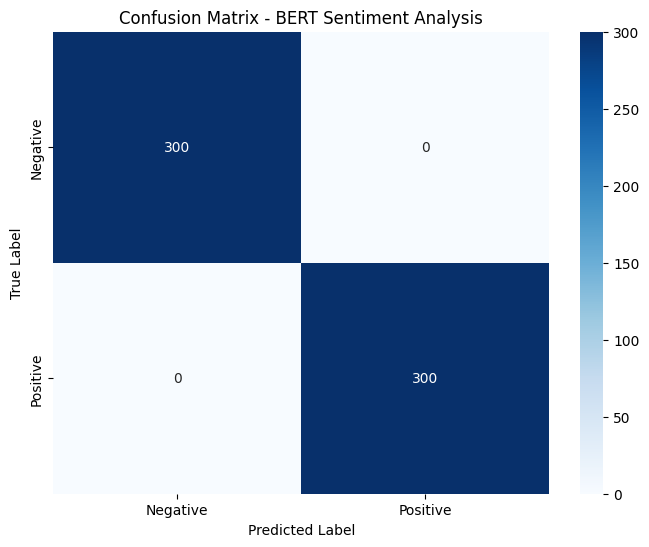


Final Model Accuracy: 1.0000 (100.00%)


In [8]:
# Evaluate the model
print("Evaluating model...")
eval_results = trainer.evaluate()

print("\nFinal Evaluation Results:")
print("-" * 40)
for key, value in eval_results.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '').title()
        print(f"{metric_name}: {value:.4f}")

# Detailed predictions analysis
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, predicted_labels,
                          target_names=['Negative', 'Positive']))

# Confusion matrix visualization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - BERT Sentiment Analysis')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate additional metrics
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nFinal Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


# Model Testing and Debugging

In [9]:
def predict_sentiment(text, model, tokenizer, device):
    """Predict sentiment for custom text with confidence score"""
    # Preprocess text
    text = preprocess_text(text)

    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probabilities, dim=-1)

    sentiment = "Positive" if prediction.item() == 1 else "Negative"
    confidence = probabilities.max().item()
    prob_scores = probabilities[0].cpu().numpy()

    return sentiment, confidence, prob_scores

# Test examples
test_examples = [
    "This movie is absolutely amazing! I loved every minute of it.",
    "Terrible movie, complete waste of time and money.",
    "The movie was okay, not great but not terrible either.",
    "Outstanding performance by all actors, brilliant storytelling!",
    "Boring and predictable plot. Couldn't wait for it to end.",
    "This film exceeded all my expectations. Simply wonderful!",
    "Disappointing movie with poor acting and weak storyline.",
    "Fantastic cinematography and excellent direction throughout.",
    "Awful film that I would never recommend to anyone.",
    "The best movie I've seen this year, highly recommended!"
]

print("Testing model with various examples:")
print("=" * 60)

for i, text in enumerate(test_examples, 1):
    sentiment, confidence, probs = predict_sentiment(text, model, tokenizer, device)
    print(f"Example {i}:")
    print(f"Text: {text}")
    print(f"Prediction: {sentiment}")
    print(f"Confidence: {confidence:.3f}")
    print(f"Probabilities: Negative={probs[0]:.3f}, Positive={probs[1]:.3f}")
    print("-" * 60)


Testing model with various examples:
Example 1:
Text: This movie is absolutely amazing! I loved every minute of it.
Prediction: Positive
Confidence: 0.999
Probabilities: Negative=0.001, Positive=0.999
------------------------------------------------------------
Example 2:
Text: Terrible movie, complete waste of time and money.
Prediction: Negative
Confidence: 0.999
Probabilities: Negative=0.999, Positive=0.001
------------------------------------------------------------
Example 3:
Text: The movie was okay, not great but not terrible either.
Prediction: Negative
Confidence: 0.982
Probabilities: Negative=0.982, Positive=0.018
------------------------------------------------------------
Example 4:
Text: Outstanding performance by all actors, brilliant storytelling!
Prediction: Positive
Confidence: 0.999
Probabilities: Negative=0.001, Positive=0.999
------------------------------------------------------------
Example 5:
Text: Boring and predictable plot. Couldn't wait for it to end.
Predic

# Performance Optimization and Debugging

In [10]:
# Memory usage analysis
def analyze_performance():
    """Analyze model performance and resource usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory Usage:")
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Cached: {cached:.2f} GB")

    # Model size analysis
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nModel Parameters:")
    print(f"  Total: {total_params:,}")
    print(f"  Trainable: {trainable_params:,}")
    print(f"  Model size: ~{total_params * 4 / 1024**2:.1f} MB")

analyze_performance()

# Inference speed benchmark
def benchmark_inference(model, tokenizer, device, num_samples=100):
    """Benchmark inference speed"""
    sample_texts = test_examples * (num_samples // len(test_examples) + 1)
    sample_texts = sample_texts[:num_samples]

    print(f"\nBenchmarking inference speed with {num_samples} samples...")

    start_time = time.time()
    for text in sample_texts:
        predict_sentiment(text, model, tokenizer, device)

    total_time = time.time() - start_time
    avg_time = total_time / num_samples

    print(f"Average inference time: {avg_time*1000:.2f} ms per sample")
    print(f"Throughput: {1/avg_time:.2f} samples per second")
    print(f"Total time for {num_samples} samples: {total_time:.2f} seconds")

benchmark_inference(model, tokenizer, device)


GPU Memory Usage:
  Allocated: 1.24 GB
  Cached: 2.46 GB

Model Parameters:
  Total: 109,483,778
  Trainable: 109,483,778
  Model size: ~417.6 MB

Benchmarking inference speed with 100 samples...
Average inference time: 12.91 ms per sample
Throughput: 77.48 samples per second
Total time for 100 samples: 1.29 seconds


# Model Improvement Techniques

In [11]:
# Error analysis
def analyze_errors():
    """Analyze model errors for debugging"""
    predictions = trainer.predict(val_dataset)
    predicted_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    # Find misclassified examples
    errors = []
    for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)):
        if pred != true:
            errors.append({
                'index': i,
                'text': val_texts[i],
                'predicted': 'Positive' if pred == 1 else 'Negative',
                'actual': 'Positive' if true == 1 else 'Negative',
                'confidence': np.max(predictions.predictions[i])
            })

    print(f"Total errors: {len(errors)} out of {len(val_texts)} ({len(errors)/len(val_texts)*100:.1f}%)")

    # Show some error examples
    print("\nError Analysis - Sample Misclassifications:")
    print("=" * 80)
    for i, error in enumerate(errors[:5]):
        print(f"Error {i+1}:")
        print(f"Text: {error['text']}")
        print(f"Predicted: {error['predicted']} (confidence: {error['confidence']:.3f})")
        print(f"Actual: {error['actual']}")
        print("-" * 80)

analyze_errors()

# Common debugging techniques
def debug_model_behavior(problematic_text):
    """Debug model behavior on specific inputs"""
    print(f"Debugging: {problematic_text}")

    # Tokenize and analyze
    tokens = tokenizer.tokenize(problematic_text)
    print(f"Tokens ({len(tokens)}): {tokens}")

    # Get model predictions with details
    inputs = tokenizer(problematic_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)

    print(f"Logits: {logits[0].cpu().numpy()}")
    print(f"Probabilities: Negative={probs[0][0]:.4f}, Positive={probs[0][1]:.4f}")
    print(f"Prediction: {'Positive' if torch.argmax(probs) == 1 else 'Negative'}")

# Debug a challenging example
debug_model_behavior("The movie was okay, not great but not terrible either.")


Total errors: 0 out of 600 (0.0%)

Error Analysis - Sample Misclassifications:
Debugging: The movie was okay, not great but not terrible either.
Tokens (12): ['the', 'movie', 'was', 'okay', ',', 'not', 'great', 'but', 'not', 'terrible', 'either', '.']
Logits: [ 2.0449219 -1.9472656]
Probabilities: Negative=0.9819, Positive=0.0181
Prediction: Negative
